# HW01

# 3 High-dimensional data

In [1]:
%%capture

from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from matplotlib import pyplot as plt

import torch
from torch.nn.modules import loss
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from tqdm.auto import tqdm

In [2]:
torch.manual_seed(0)

In [3]:
DEVICE = torch.device("cuda")

In [4]:
class MaskedConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, mask_type):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)        
        self.mask = torch.ones(self.weight.shape).to(DEVICE)
        self.mask[:, :, self.weight.shape[2] // 2, self.weight.shape[3] // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, self.weight.shape[2] // 2 + 1:] = 0
        
    def forward(self, input):
#         return torch.nn.functional.conv2d(input, self.mask * self.weight, stride=self.stride, padding=self.padding)
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(input)

In [5]:
class MaskedResBlock(nn.Module):
    def __init__(self):
        super(MaskedResBlock, self).__init__()
        size = 16
        
        self.model = nn.Sequential(
            nn.ReLU(),
            MaskedConv2d(size, size, kernel_size=1, stride=1, padding=0, mask_type='B'),
            nn.BatchNorm2d(size),
            nn.ReLU(),
            MaskedConv2d(size, size, kernel_size=3, stride=1, padding=1, mask_type='B'),
            nn.BatchNorm2d(size),
            nn.ReLU(),
            MaskedConv2d(size, size, kernel_size=1, stride=1, padding=0, mask_type='B'),
            nn.BatchNorm2d(size)
        )

    def forward(self, x):
        return self.model(x) + x

In [6]:
class PixelCNN(nn.Module):
    def __init__(self):
        super(PixelCNN, self).__init__()
        size = 16

        self.model = nn.Sequential(
            MaskedConv2d(3, size, kernel_size=7, stride=1, padding=3, mask_type='A'),
            
            MaskedResBlock(), MaskedResBlock(), MaskedResBlock(), MaskedResBlock(),
            MaskedResBlock(), MaskedResBlock(), MaskedResBlock(), MaskedResBlock(),
            MaskedResBlock(), MaskedResBlock(), MaskedResBlock(), MaskedResBlock(),
            
            nn.ReLU(),
            MaskedConv2d(size, size, kernel_size=1, stride=1, padding=0, mask_type='B'),
            nn.BatchNorm2d(size),
            nn.ReLU(),
            MaskedConv2d(size, 3 * 4, kernel_size=1, stride=1, padding=0, mask_type='B'),
        )

    def forward(self, x):
        x = x.float()
        
        out = self.model(x)
        out = out.reshape(x.shape[0], x.shape[1], 4, x.shape[2], x.shape[3])
        out = out.permute(0, 1, 3, 4, 2)
        
        return out

In [7]:
def one_hot_v2(batch,depth):
    ones = torch.sparse.torch.eye(depth).to(DEVICE)
    return ones.index_select(0,batch)

def MyNLLLoss(x, y):
    y = torch.nn.functional.softmax(y, dim=4).to(DEVICE)
    x4 = x[:, :, :, :]
    one_hot = torch.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3], 4)).float().to(DEVICE)
    one_hot[:, :, :, :] = one_hot_v2(x4.view(-1).long(),4).view(one_hot.shape)
    
    out = (y * one_hot)
    out = out.sum(dim=-1)
    loss = -torch.log(out)
    loss = loss.mean()
    
    return loss

In [8]:
def sample_data():
    with open('../mnist-hw1.pkl', 'rb') as dataset_file:
        dataset = pickle.load(dataset_file)

    X_train = dataset['train']
    X_test = dataset['test']
    return X_train, X_test

In [9]:
def fit(model, X_train, X_val, X_test, optimizer, loss_function, epoch_cnt, batch_size):
    val_size = len(X_val)
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(X_val, batch_size=len(X_val))
    test_loader = torch.utils.data.DataLoader(X_test, batch_size=len(X_test))
    train_loss_values = []
    val_loss_values = []
            
    for epoch in tqdm(range(epoch_cnt)):
        for batch_data in train_loader:
            batch_data = batch_data.to(DEVICE)
            optimizer.zero_grad()
            output = model(batch_data)
            loss = loss_function(batch_data, output)
            train_loss_values.append(loss / 2)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for batch_data in val_loader:
                batch_data = batch_data.to(DEVICE)
                output = model(batch_data)
                loss = loss_function(batch_data, output)
                val_loss_values.append(loss / 2)

    with torch.no_grad():
        for batch_data in test_loader:
            batch_data = batch_data.to(DEVICE)
            output = model(batch_data)
            loss = loss_function(batch_data, output)
            print("Test set loss: {:.6f}".format(loss / 2))

    return train_loss_values, val_loss_values 


In [10]:
X_train, X_test = sample_data()
X_train, X_val = train_test_split(X_train, test_size=0.125, random_state=42)

In [11]:
X_train = X_train.transpose([0, 3, 1, 2])
X_val = X_val.transpose([0, 3, 1, 2])
X_test = X_test.transpose([0, 3, 1, 2])

In [97]:
# del model
torch.cuda.empty_cache()

In [12]:
model = PixelCNN()
model = model.float()
model = model.to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
loss_function = MyNLLLoss

In [13]:
epoch_cnt = 20
batch_size = 256
train_loss_values, val_loss_values =\
    fit(model, X_train, X_val, X_test, optimizer, loss_function, epoch_cnt, batch_size)


Test set loss: 0.143649


In [14]:
def plot_loss_values(train_loss_values, val_loss_values):
    plt.plot(np.arange(len(train_loss_values)), train_loss_values, color='blue', label='train')
    plt.plot(np.arange(0, len(train_loss_values), len(train_loss_values) / epoch_cnt), val_loss_values, color='red', label='validation')
    plt.legend()
    plt.title("Loss values")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

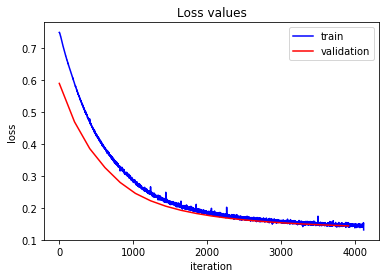

In [15]:
plot_loss_values(train_loss_values, val_loss_values)

In [16]:
def receptive_field(model, X, loss_function):
    half_size = 14
    
    x = torch.tensor(X.astype(np.float32), requires_grad=True).to(DEVICE)    
    y = model(x)
    y = y[:, 0, half_size, half_size].reshape(-1, 1, 1, 1, 4)
    batch_data = torch.tensor(X)
    batch_data = batch_data[:, 0, half_size, half_size].reshape(-1, 1, 1, 1).to(DEVICE)
    
    loss = loss_function(batch_data, y)
    x.retain_grad()
    loss.backward()

    grad = x.grad
    img = grad.abs().sum(dim=(0, 1)).float().cpu().numpy()
    
    plt.imshow(img)
    plt.show()

In [18]:
torch.save(model.state_dict(), "./models/pixelcnn_size16_bath256_epoch20.pt")
torch.save(model, "./models/pixelcnn_size16_bath256_epoch20.pt")

C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type PixelCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type MaskedConv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type MaskedResBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


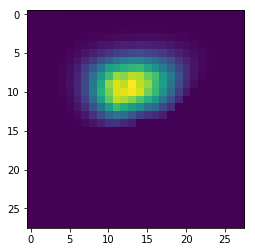

In [19]:
model2 = PixelCNN()
model2.to(DEVICE)
receptive_field(model2, X_test[:200], MyNLLLoss)

In [25]:
def generate_samples(model, cnt):
    size = 28
    samples = np.zeros((cnt, size, size, 3), dtype=np.uint8)
    
    with torch.no_grad():
        for i in tqdm(range(size)):
            for j in range(size):
                x = torch.tensor(samples.transpose([0, 3, 1, 2])).to(DEVICE)
                y = model(x)
                y = torch.nn.functional.softmax(y, dim=4).cpu().numpy()
                
                for k in range(cnt):
                    for c in range(3):
                        samples[k, i, j, c] = np.random.choice(4, p=y[k, c, i, j])

    return samples

def plot_samples(samples, cnt):
    round = int(np.ceil(np.sqrt(cnt)))
    f, axs = plt.subplots(round, round)
    f.set_figheight(12)
    f.set_figwidth(12)
    
    for i, img in enumerate(samples):
        axs[i // round, i % round].imshow(img)
        axs[i // round, i % round].axis('off')
    
    plt.show()

In [26]:
generated_samples = generate_samples(model, 100)

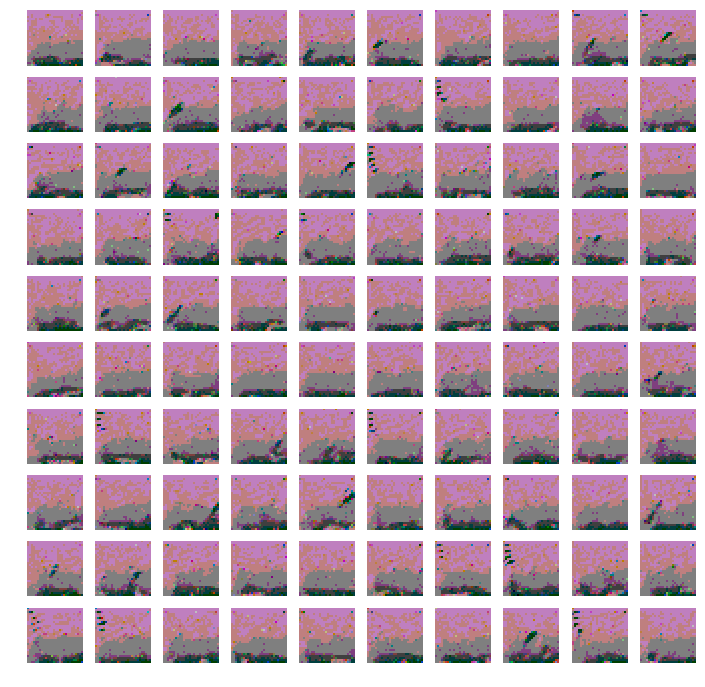

In [32]:
generated_samples1 = generated_samples.astype(int) * 255 // 4
plot_samples(generated_samples1, 100)